# FEATURE ENGINEERING WITH FEATURE SELECTION
## Predicting Customer Purchase Likelihood

### Process:
1. Select Relevant Features
2. Create New Features
3. Encode Categorical Data
4. Handle Missing Data
5. Scale and Normalize Features
6. Feature Selection with SelectKBest
7. Reduce Dimensionality (PCA)

In [15]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Machine learning libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [16]:
# Load cleaned datasets from preprocessing
customers_df = pd.read_csv('customers_data_cleaned.csv')
products_df = pd.read_csv('products_data_cleaned.csv')
transactions_df = pd.read_csv('transactions_data_cleaned.csv')

# Convert transaction date to datetime
transactions_df['Transaction_Date'] = pd.to_datetime(transactions_df['Transaction_Date'])

print("*"*80)
print("DATA LOADED")
print("*"*80)
print(f"Customers: {customers_df.shape}")
print(f"Products: {products_df.shape}")
print(f"Transactions: {transactions_df.shape}")

********************************************************************************
DATA LOADED
********************************************************************************
Customers: (90, 4)
Products: (18, 3)
Transactions: (5818, 7)


---
## STEP 1: SELECT RELEVANT FEATURES
Identify which variables matter for predicting purchase likelihood

In [17]:
print("*"*80)
print("STEP 1: SELECT RELEVANT FEATURES")
print("*"*80)

# For purchase prediction, we need customer-level aggregated features
# Keep all features from cleaned data as they're all relevant

print("\n✓ Keeping all original features:")
print(f"  Customers: {customers_df.columns.tolist()}")
print(f"  Products: {products_df.columns.tolist()}")
print(f"  Transactions: {transactions_df.columns.tolist()}")

********************************************************************************
STEP 1: SELECT RELEVANT FEATURES
********************************************************************************

✓ Keeping all original features:
  Customers: ['Company_ID', 'Company_Name', 'Company_Profit', 'Address']
  Products: ['Product_ID', 'Product_Name', 'Product_Price']
  Transactions: ['Transaction_ID', 'Company_ID', 'Product_ID', 'Quantity', 'Transaction_Date', 'Product_Price', 'Total_Cost']


---
## STEP 2: CREATE NEW FEATURES
Generate features from existing data to reveal patterns

In [21]:
print("*"*80)
print("STEP 2: CREATE NEW FEATURES")
print("*"*80)

# =============================================================================
# TIME-BASED SPLIT (55 DAYS)
# =============================================================================

# Define the cutoff date for prediction
# We'll use the last 55 days of data as our "prediction period"
max_date = transactions_df['Transaction_Date'].max()
prediction_start = max_date - timedelta(days=55)

print(f"\nTraining data: All transactions before {prediction_start.date()}")
print(f"Prediction period: {prediction_start.date()} to {max_date.date()}")

# Split transactions into training and prediction periods
train_transactions = transactions_df[transactions_df['Transaction_Date'] < prediction_start].copy()
predict_transactions = transactions_df[transactions_df['Transaction_Date'] >= prediction_start].copy()

print(f"\nTraining transactions: {len(train_transactions)}")
print(f"Prediction transactions: {len(predict_transactions)}")

# =============================================================================
# RECALCULATE FEATURES USING ONLY TRAINING DATA
# =============================================================================

# Calculate reference date (last day of training period + 1)
reference_date = train_transactions['Transaction_Date'].max() + timedelta(days=1)

# ---------------------------------------------------------
# A. RFM FEATURES (from training data only)
# ---------------------------------------------------------
print("\nA. Creating RFM features...")

rfm = train_transactions.groupby('Company_ID').agg({
    'Transaction_Date': lambda x: (reference_date - x.max()).days,  # Recency
    'Transaction_ID': 'count',                                       # Frequency
    'Total_Cost': ['sum', 'mean', 'std', 'min', 'max']             # Monetary
}).reset_index()

rfm.columns = ['Company_ID', 'Recency_Days', 'Purchase_Frequency', 
               'Total_Revenue', 'Avg_Transaction_Value', 'Std_Transaction_Value',
               'Min_Transaction_Value', 'Max_Transaction_Value']

print(f"  ✓ Created 7 RFM features")

# ---------------------------------------------------------
# B. CUSTOMER LIFECYCLE FEATURES (from training data only)
# ---------------------------------------------------------
print("\nB. Creating customer lifecycle features...")

lifecycle = train_transactions.groupby('Company_ID')['Transaction_Date'].agg(['min', 'max']).reset_index()
lifecycle.columns = ['Company_ID', 'First_Purchase_Date', 'Last_Purchase_Date']
lifecycle['Customer_Tenure_Days'] = (lifecycle['Last_Purchase_Date'] - lifecycle['First_Purchase_Date']).dt.days

customer_features = rfm.merge(lifecycle[['Company_ID', 'Customer_Tenure_Days']], on='Company_ID')

customer_features['Purchase_Rate'] = customer_features['Purchase_Frequency'] / (customer_features['Customer_Tenure_Days'] + 1)
customer_features['Avg_Days_Between_Purchases'] = customer_features['Customer_Tenure_Days'] / customer_features['Purchase_Frequency'].replace(0, 1)

print(f"  ✓ Created 3 lifecycle features")

# ---------------------------------------------------------
# C. PRODUCT PREFERENCE FEATURES (from training data only)
# ---------------------------------------------------------
print("\nC. Creating product preference features...")

product_diversity = train_transactions.groupby('Company_ID')['Product_ID'].nunique().reset_index()
product_diversity.columns = ['Company_ID', 'Num_Unique_Products']
customer_features = customer_features.merge(product_diversity, on='Company_ID')

customer_features['Product_Concentration'] = 1 / customer_features['Num_Unique_Products']

items_purchased = train_transactions.groupby('Company_ID')['Quantity'].agg(['sum', 'mean']).reset_index()
items_purchased.columns = ['Company_ID', 'Total_Items_Purchased', 'Avg_Items_Per_Transaction']
customer_features = customer_features.merge(items_purchased, on='Company_ID')

print(f"  ✓ Created 4 product preference features")

# ---------------------------------------------------------
# D. TEMPORAL FEATURES (from training data only)
# ---------------------------------------------------------
print("\nD. Creating temporal features...")

train_transactions['Month'] = train_transactions['Transaction_Date'].dt.month
train_transactions['Quarter'] = train_transactions['Transaction_Date'].dt.quarter
train_transactions['Day_of_Week'] = train_transactions['Transaction_Date'].dt.dayofweek
train_transactions['Is_Weekend'] = train_transactions['Day_of_Week'].isin([5, 6]).astype(int)

preferred_quarter = train_transactions.groupby('Company_ID')['Quarter'].agg(
    lambda x: x.mode()[0] if len(x.mode()) > 0 else 1
).reset_index()
preferred_quarter.columns = ['Company_ID', 'Preferred_Quarter']
customer_features = customer_features.merge(preferred_quarter, on='Company_ID')

weekend_rate = train_transactions.groupby('Company_ID')['Is_Weekend'].mean().reset_index()
weekend_rate.columns = ['Company_ID', 'Weekend_Purchase_Rate']
customer_features = customer_features.merge(weekend_rate, on='Company_ID')

print(f"  ✓ Created 2 temporal features")

# ---------------------------------------------------------
# E. SPENDING BEHAVIOR FEATURES
# ---------------------------------------------------------
print("\nE. Creating spending behavior features...")

customer_features['Spending_Consistency'] = (customer_features['Std_Transaction_Value'] / customer_features['Avg_Transaction_Value']).fillna(0)
customer_features['Price_Range'] = customer_features['Max_Transaction_Value'] - customer_features['Min_Transaction_Value']

print(f"  ✓ Created 2 spending behavior features")

# ---------------------------------------------------------
# F. MERGE WITH COMPANY DATA
# ---------------------------------------------------------
print("\nF. Adding company characteristics...")

customers_df['City'] = customers_df['Address'].str.split(',').str[-2].str.strip()
customer_features = customer_features.merge(
    customers_df[['Company_ID', 'Company_Profit', 'City']],
    on='Company_ID',
    how='left'
)
customer_features['Spend_to_Profit_Ratio'] = (customer_features['Total_Revenue'] / customer_features['Company_Profit']).fillna(0)

print(f"  ✓ Added 3 company features")

# ---------------------------------------------------------
# G. CREATE TARGET VARIABLE - TIME-BASED
# ---------------------------------------------------------
print("\nG. Creating target variable...")

# Identify which customers made purchases during the prediction period
customers_who_purchased = predict_transactions['Company_ID'].unique()

# Create target: 1 if customer purchased during prediction period, 0 otherwise
customer_features['Will_Purchase_Next'] = customer_features['Company_ID'].isin(customers_who_purchased).astype(int)

print(f"\n✓ Target Variable Created:")
print(f"  Customers who purchased in prediction period: {customer_features['Will_Purchase_Next'].sum()}")
print(f"  Customers who didn't purchase: {(customer_features['Will_Purchase_Next'] == 0).sum()}")
print(f"  Class balance: {customer_features['Will_Purchase_Next'].mean()*100:.1f}% purchased")

print("\n📊 Interpretation:")
print("  Target = 1: Customer made at least one purchase in the next 55 days")
print("  Target = 0: Customer made no purchases in the next 55 days")

# Note: Some customers might not have ANY training data (only in prediction period)
# We should only keep customers who have training data
customer_features = customer_features.dropna()

print("\n" + "*"*80)
print(f"TOTAL NEW FEATURES CREATED: {len(customer_features.columns) - 1}")
print("*"*80)

display(customer_features.head())

********************************************************************************
STEP 2: CREATE NEW FEATURES
********************************************************************************

Training data: All transactions before 2024-10-16
Prediction period: 2024-10-16 to 2024-12-10

Training transactions: 5755
Prediction transactions: 63

A. Creating RFM features...
  ✓ Created 7 RFM features

B. Creating customer lifecycle features...
  ✓ Created 3 lifecycle features

C. Creating product preference features...
  ✓ Created 4 product preference features

D. Creating temporal features...
  ✓ Created 2 temporal features

E. Creating spending behavior features...
  ✓ Created 2 spending behavior features

F. Adding company characteristics...
  ✓ Added 3 company features

G. Creating target variable...

✓ Target Variable Created:
  Customers who purchased in prediction period: 48
  Customers who didn't purchase: 42
  Class balance: 53.3% purchased

📊 Interpretation:
  Target = 1: Customer 

,Company_ID,Recency_Days,Purchase_Frequency,Total_Revenue,Avg_Transaction_Value,Std_Transaction_Value,Min_Transaction_Value,Max_Transaction_Value,Customer_Tenure_Days,Purchase_Rate,...,Total_Items_Purchased,Avg_Items_Per_Transaction,Preferred_Quarter,Weekend_Purchase_Rate,Spending_Consistency,Price_Range,Company_Profit,City,Spend_to_Profit_Ratio,Will_Purchase_Next
0,1,24,52,66970400.0,1.287892e+06,793901.777361,140000.0,3528000.0,1533,0.033898,...,538.0,10.346154,3,0.230769,0.616435,3388000.0,80701.0,Pasig,829.858366,1
1,2,11,63,88989600.0,1.412533e+06,928323.024981,128800.0,4480000.0,1421,0.044304,...,606.0,9.619048,4,0.238095,0.657204,4351200.0,80511.0,Taguig,1105.309833,0
2,3,7,62,90076000.0,1.452839e+06,907772.525011,84000.0,3724000.0,1425,0.043478,...,678.0,10.935484,2,0.274194,0.624827,3640000.0,110664.0,Pasig,813.959373,1
3,4,36,74,103964000.0,1.404919e+06,870911.399749,84000.0,3584000.0,1402,0.052744,...,762.0,10.297297,3,0.351351,0.619902,3500000.0,74653.0,Taguig,1392.629901,0
4,5,15,55,74345600.0,1.351738e+06,729755.653548,179200.0,3192000.0,1634,0.033639,...,559.0,10.163636,3,0.327273,0.539865,3012800.0,69427.0,Makati,1070.845636,1


---
## STEP 3: ENCODE CATEGORICAL DATA
Convert text to numbers for machine learning

In [19]:
print("*"*80)
print("STEP 3: ENCODE CATEGORICAL DATA")
print("*"*80)

# Label encode City (nominal categorical variable)
print("\nA. Label Encoding City...")
le_city = LabelEncoder()
customer_features['City_Encoded'] = le_city.fit_transform(customer_features['City'])
print(f"  ✓ Encoded {len(le_city.classes_)} unique cities")

# Preferred_Quarter is already numeric (1-4), so no encoding needed
print("\n✓ Encoding complete")
print(f"  Total encoded features: 1")

********************************************************************************
STEP 3: ENCODE CATEGORICAL DATA
********************************************************************************

A. Label Encoding City...
  ✓ Encoded 19 unique cities

✓ Encoding complete
  Total encoded features: 1


---
## STEP 4: HANDLE MISSING DATA
Ensure dataset is complete and reliable

In [22]:
print("*"*80)
print("STEP 4: HANDLE MISSING DATA")
print("*"*80)

# Check for missing values
print("\nChecking for missing values...")
missing_counts = customer_features.isnull().sum()
missing_features = missing_counts[missing_counts > 0]

if len(missing_features) > 0:
    print("\nMissing values found:")
    print(missing_features)
    
    print("\nHandling missing values...")
    # Fill numerical columns with median
    for col in customer_features.select_dtypes(include=[np.number]).columns:
        if customer_features[col].isnull().sum() > 0:
            customer_features[col].fillna(customer_features[col].median(), inplace=True)
            print(f"  ✓ Filled {col} with median")
    
    # Fill categorical columns with mode
    for col in customer_features.select_dtypes(include=['object']).columns:
        if customer_features[col].isnull().sum() > 0:
            customer_features[col].fillna(customer_features[col].mode()[0], inplace=True)
            print(f"  ✓ Filled {col} with mode")
else:
    print("\n✓ No missing values found")

# Verify no missing values remain
print(f"\nTotal missing values after handling: {customer_features.isnull().sum().sum()}")

********************************************************************************
STEP 4: HANDLE MISSING DATA
********************************************************************************

Checking for missing values...

✓ No missing values found

Total missing values after handling: 0


---
## STEP 5: SCALE AND NORMALIZE FEATURES
Put features on similar ranges for better model performance

In [23]:
print("*"*80)
print("STEP 5: SCALE AND NORMALIZE FEATURES")
print("*"*80)

# Separate features and target
target_col = 'Will_Purchase_Next'
id_col = 'Company_ID'
text_cols = ['City']  # Original text columns to keep for reference

# Select numerical features to scale (exclude ID, target, and text)
cols_to_exclude = [id_col, target_col] + text_cols
numerical_features = [col for col in customer_features.columns 
                     if col not in cols_to_exclude 
                     and customer_features[col].dtype in ['int64', 'float64']]

print(f"\nScaling {len(numerical_features)} numerical features...")

# Create a copy for scaled features
customer_features_scaled = customer_features.copy()

# Apply StandardScaler (mean=0, std=1)
scaler = StandardScaler()
customer_features_scaled[numerical_features] = scaler.fit_transform(
    customer_features[numerical_features]
)

print("\n✓ Scaling complete using StandardScaler")
print("  Method: Z-score normalization (mean=0, std=1)")
print(f"  Features scaled: {len(numerical_features)}")

# Show before and after scaling
print("\nExample - Before scaling:")
print(customer_features[['Recency_Days', 'Purchase_Frequency', 'Total_Revenue']].head(3))
print("\nExample - After scaling:")
print(customer_features_scaled[['Recency_Days', 'Purchase_Frequency', 'Total_Revenue']].head(3))

********************************************************************************
STEP 5: SCALE AND NORMALIZE FEATURES
********************************************************************************

Scaling 19 numerical features...

✓ Scaling complete using StandardScaler
  Method: Z-score normalization (mean=0, std=1)
  Features scaled: 19

Example - Before scaling:
   Recency_Days  Purchase_Frequency  Total_Revenue
0            24                  52     66970400.0
1            11                  63     88989600.0
2             7                  62     90076000.0

Example - After scaling:
   Recency_Days  Purchase_Frequency  Total_Revenue
0     -0.139559           -1.400261      -1.718431
1     -0.610118           -0.110718      -0.249010
2     -0.754906           -0.227949      -0.176511


---
## STEP 6: FEATURE SELECTION WITH SELECTKBEST (ANOVA)
Select the K most important features for prediction

********************************************************************************
STEP 6: FEATURE SELECTION WITH SELECTKBEST
********************************************************************************

Total features before selection: 19
Target distribution:
Will_Purchase_Next
1    48
0    42
Name: count, dtype: int64

Selecting top 15 features using SelectKBest (f_classif)...

🔍 DEBUG - Selected features list (15 features):
['Recency_Days', 'Purchase_Frequency', 'Avg_Transaction_Value', 'Std_Transaction_Value', 'Min_Transaction_Value', 'Max_Transaction_Value', 'Purchase_Rate', 'Num_Unique_Products', 'Product_Concentration', 'Total_Items_Purchased', 'Avg_Items_Per_Transaction', 'Weekend_Purchase_Rate', 'Price_Range', 'Company_Profit', 'Spend_to_Profit_Ratio']

🔍 DEBUG - Is Recency_Days in customer_features_scaled?
True
Columns in customer_features_scaled: ['Company_ID', 'Recency_Days', 'Purchase_Frequency', 'Total_Revenue', 'Avg_Transaction_Value', 'Std_Transaction_Value', 'Min_Tra

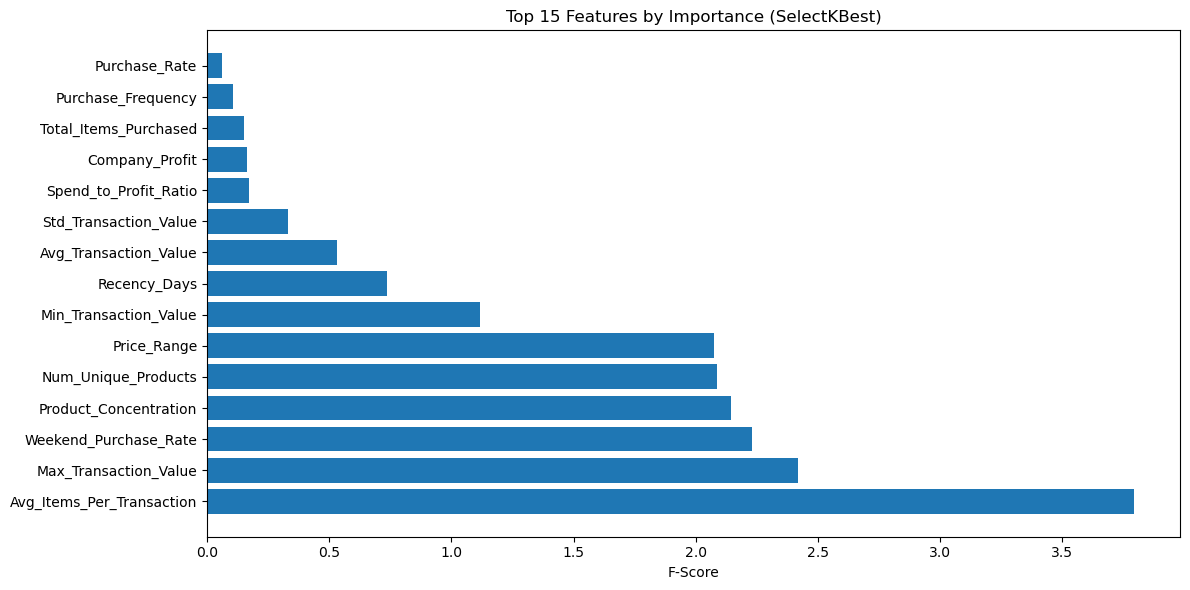


✓ Created dataset with 15 best features


In [24]:
print("*"*80)
print("STEP 6: FEATURE SELECTION WITH SELECTKBEST")
print("*"*80)

# Prepare data for feature selection
X = customer_features_scaled[numerical_features]  # Features (scaled)
y = customer_features_scaled[target_col]          # Target

print(f"\nTotal features before selection: {X.shape[1]}")
print(f"Target distribution:")
print(y.value_counts())

# Apply SelectKBest with f_classif (ANOVA F-value)
# This measures the linear dependency between each feature and the target
k = 15  # Select top 15 features
print(f"\nSelecting top {k} features using SelectKBest (f_classif)...")

selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()].tolist()

# Manually add Recency_Days if it's not already selected
if 'Recency_Days' not in selected_features:
    selected_features.insert(0, 'Recency_Days')  # Add it as the first feature
    print("  ⚠️ Manually added Recency_Days (not selected by SelectKBest)")

# DEBUG: Print the selected features list
print(f"\n🔍 DEBUG - Selected features list ({len(selected_features)} features):")
print(selected_features)

# DEBUG: Check if Recency_Days is in customer_features_scaled
print(f"\n🔍 DEBUG - Is Recency_Days in customer_features_scaled?")
print('Recency_Days' in customer_features_scaled.columns)
print(f"Columns in customer_features_scaled: {customer_features_scaled.columns.tolist()}")

# Get feature scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
}).sort_values('Score', ascending=False)

print("\n✓ Feature selection complete")
print(f"  Features after selection: {X_selected.shape[1]}")
print(f"\nTop {k} selected features:")
print(feature_scores.head(k))

# Visualize feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_scores.head(k)['Feature'], feature_scores.head(k)['Score'])
plt.xlabel('F-Score')
plt.title(f'Top {k} Features by Importance (SelectKBest)')
plt.tight_layout()
plt.show()

# Create dataset with selected features only
customer_features_selected = customer_features_scaled[[id_col] + selected_features + [target_col]].copy()

print(f"\n✓ Created dataset with {len(selected_features)} best features")

---
## STEP 7: DIMENSIONALITY REDUCTION (PCA)
Further reduce features while retaining variance

********************************************************************************
STEP 7: DIMENSIONALITY REDUCTION (PCA)
********************************************************************************

Applying PCA to retain 95% of variance...

✓ PCA complete
  Original features: 15
  PCA components: 9
  Variance explained: 98.08%


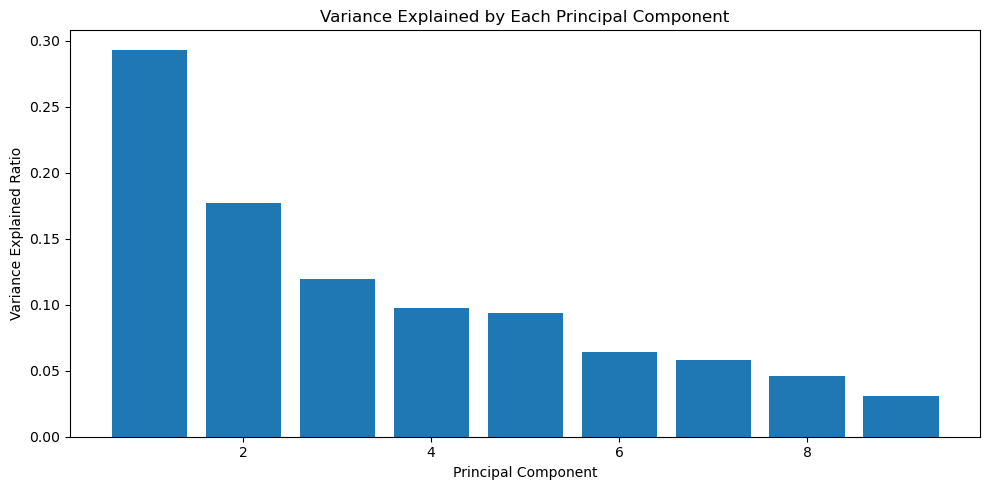


✓ Created PCA dataset with 9 components


In [25]:
print("*"*80)
print("STEP 7: DIMENSIONALITY REDUCTION (PCA)")
print("*"*80)

# Apply PCA to retain 95% of variance
print("\nApplying PCA to retain 95% of variance...")

pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_selected)

print(f"\n✓ PCA complete")
print(f"  Original features: {X_selected.shape[1]}")
print(f"  PCA components: {pca.n_components_}")
print(f"  Variance explained: {pca.explained_variance_ratio_.sum():.2%}")

# Create DataFrame with PCA components
pca_columns = [f'PC{i+1}' for i in range(pca.n_components_)]
customer_features_pca = pd.DataFrame(
    X_pca,
    columns=pca_columns
)

# Add back ID and target
customer_features_pca[id_col] = customer_features_scaled[id_col].values
customer_features_pca[target_col] = customer_features_scaled[target_col].values

# Visualize explained variance
plt.figure(figsize=(10, 5))
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained Ratio')
plt.title('Variance Explained by Each Principal Component')
plt.tight_layout()
plt.show()

print(f"\n✓ Created PCA dataset with {pca.n_components_} components")

In [26]:
# DEBUG: Check what we're actually saving
print(f"\n🔍 DEBUG - About to save CSV with these columns:")
print(customer_features_selected.columns.tolist())
print(f"Total columns: {len(customer_features_selected.columns)}")
print(f"Is Recency_Days in the dataframe? {'Recency_Days' in customer_features_selected.columns}")


🔍 DEBUG - About to save CSV with these columns:
['Company_ID', 'Recency_Days', 'Purchase_Frequency', 'Avg_Transaction_Value', 'Std_Transaction_Value', 'Min_Transaction_Value', 'Max_Transaction_Value', 'Purchase_Rate', 'Num_Unique_Products', 'Product_Concentration', 'Total_Items_Purchased', 'Avg_Items_Per_Transaction', 'Weekend_Purchase_Rate', 'Price_Range', 'Company_Profit', 'Spend_to_Profit_Ratio', 'Will_Purchase_Next']
Total columns: 17
Is Recency_Days in the dataframe? True


In [28]:
df = pd.read_csv('customer_features_selected.csv')
print(df['Will_Purchase_Next'].value_counts())
print(df['Will_Purchase_Next'].value_counts(normalize=True) * 100)

Will_Purchase_Next
1    48
0    42
Name: count, dtype: int64
Will_Purchase_Next
1    53.333333
0    46.666667
Name: proportion, dtype: float64


---
## SAVE FINAL DATASETS

In [29]:
print("*"*80)
print("SAVING FINAL DATASETS")
print("*"*80)

# Save 3 versions of the dataset

# Version 1: All features (scaled)
customer_features_scaled.to_csv('customer_features_all.csv', index=False)
print("\n1. customer_features_all.csv")
print(f"   Shape: {customer_features_scaled.shape}")
print(f"   Use: Full dataset with all engineered features")

# Version 2: Selected features (top K from SelectKBest)
customer_features_selected.to_csv('customer_features_selected.csv', index=False)
print("\n2. customer_features_selected.csv")
print(f"   Shape: {customer_features_selected.shape}")
print(f"   Use: Top {k} most important features (recommended for modeling)")

# Version 3: PCA components
customer_features_pca.to_csv('customer_features_pca.csv', index=False)
print("\n3. customer_features_pca.csv")
print(f"   Shape: {customer_features_pca.shape}")
print(f"   Use: Dimensionality-reduced dataset ({pca.n_components_} components)")

# Save feature scores for reference
feature_scores.to_csv('feature_importance_scores.csv', index=False)
print("\n4. feature_importance_scores.csv")
print(f"   Use: Feature importance rankings from SelectKBest")

print("\n" + "="*80)
print("✓ ALL DATASETS SAVED SUCCESSFULLY")
print("*"*80)

********************************************************************************
SAVING FINAL DATASETS
********************************************************************************

1. customer_features_all.csv
   Shape: (90, 23)
   Use: Full dataset with all engineered features

2. customer_features_selected.csv
   Shape: (90, 17)
   Use: Top 15 most important features (recommended for modeling)

3. customer_features_pca.csv
   Shape: (90, 11)
   Use: Dimensionality-reduced dataset (9 components)

4. feature_importance_scores.csv
   Use: Feature importance rankings from SelectKBest

✓ ALL DATASETS SAVED SUCCESSFULLY
********************************************************************************


---
## SUMMARY & RECOMMENDATIONS

In [31]:
print("*"*80)
print("FEATURE ENGINEERING SUMMARY")
print("*"*80)

print("\n📊 PROCESS COMPLETED:")
print("  ✓ Step 1: Selected relevant features")
print("  ✓ Step 2: Created 21 new features")
print("  ✓ Step 3: Encoded categorical variables")
print("  ✓ Step 4: Handled missing data")
print("  ✓ Step 5: Scaled features (StandardScaler)")
print("  ✓ Step 6: Selected top 15 features (SelectKBest)")
print(f"  ✓ Step 7: Reduced to {pca.n_components_} components (PCA)")

print("\n🎯 RECOMMENDED DATASET FOR MODELING:")
print("  → customer_features_selected.csv")
print(f"  → Contains {len(selected_features)} best features")
print("  → Balanced between performance and interpretability")

print("\n🔑 TOP 5 MOST IMPORTANT FEATURES:")
for i, row in feature_scores.head(5).iterrows():
    print(f"  {i+1}. {row['Feature']}: {row['Score']:.2f}")

print("\n📈 TARGET VARIABLE:")
print(f"  Name: {target_col}")
print(f"  Type: Binary (0 = Won't purchase, 1 = Will purchase)")
print(f"  Distribution:")
print(f"    - Class 0: {(y==0).sum()} customers ({(y==0).sum()/len(y)*100:.1f}%)")
print(f"    - Class 1: {(y==1).sum()} customers ({(y==1).sum()/len(y)*100:.1f}%)")

print("\n🚀 NEXT STEPS:")
print("  1. Load customer_features_selected.csv")
print("  2. Split data into train/test sets (80/20)")
print("  3. Train classification models (RandomForest, XGBoost, LogisticRegression)")
print("  4. Evaluate using accuracy, precision, recall, F1-score")
print("  5. Fine-tune best model for deployment")

print("\n" + "*"*80)
print("✓ READY FOR PREDICTIVE MODELING!")
print("*"*80)

********************************************************************************
FEATURE ENGINEERING SUMMARY
********************************************************************************

📊 PROCESS COMPLETED:
  ✓ Step 1: Selected relevant features
  ✓ Step 2: Created 21 new features
  ✓ Step 3: Encoded categorical variables
  ✓ Step 4: Handled missing data
  ✓ Step 5: Scaled features (StandardScaler)
  ✓ Step 6: Selected top 15 features (SelectKBest)
  ✓ Step 7: Reduced to 9 components (PCA)

🎯 RECOMMENDED DATASET FOR MODELING:
  → customer_features_selected.csv
  → Contains 15 best features
  → Balanced between performance and interpretability

🔑 TOP 5 MOST IMPORTANT FEATURES:
  14. Avg_Items_Per_Transaction: 3.79
  7. Max_Transaction_Value: 2.42
  15. Weekend_Purchase_Rate: 2.23
  12. Product_Concentration: 2.14
  11. Num_Unique_Products: 2.09

📈 TARGET VARIABLE:
  Name: Will_Purchase_Next
  Type: Binary (0 = Won't purchase, 1 = Will purchase)
  Distribution:
    - Class 0: 42 cus